<a href="https://colab.research.google.com/github/guyez/NLP/blob/main/DistilBertQA_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


## Advantages of Fine-Tuning



We will use different transformers to train a question answering model. Specifically, we will take the pre-trained transformer models, add an untrained layer of neurons on the end, and train the new model for our question answering task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the question answering task? 

1. **Quicker Development**

    * First, the pre-trained transformer models weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our question answering task. In fact, fine-tune a transformer, on a specific NLP task, take only 2-4 epochs of training  (compared to the hundreds of GPU hours needed to train the original transformer model or a LSTM from scratch!). 

2. **Less Data**

    * In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning a transformer, we are now able to get away with training a model to good performance on a much smaller amount of training data.

3. **Better Results**

    * Finally, this simple fine-tuning procedure was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning a transformer is shown to be a better (or at least equal) alternative.



### A Shift in NLP

This shift to transfer learning parallels the same shift that took place in computer vision a few years ago. Creating a good deep learning network for computer vision tasks can take millions of parameters and be very expensive to train. Researchers discovered that deep networks learn hierarchical feature representations (simple features like edges at the lowest layers with gradually more complex features at higher layers). Rather than training a new network from scratch each time, the lower layers of a trained network with generalized image features could be copied and transfered for use in another network with a different task. It soon became common practice to download a pre-trained deep network and quickly retrain it for the new task or add additional layers on top - vastly preferable to the expensive process of training a network from scratch. For many, the introduction of deep pre-trained language models in 2018 (ELMO, BERT, ULMFIT, Open-GPT, etc.) signals the same shift to transfer learning in NLP that computer vision saw.

Let's get started!

# Import Dependencies


Let's install the [transformers](https://github.com/huggingface/transformers) and [datasets](https://github.com/huggingface/datasets) packages from Hugging Face which will give us a pytorch interface for working with transformers. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with transformers. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc.

Datasets is a lightweight library providing simple, fast and reproducible data pre-processing for the public datasets as well as your own local datasets in CSV/JSON/text. With simple commandes like `tokenized_dataset = dataset.map(tokenize_exemple)` efficiently prepare the dataset for inspection and ML model evaluation and training.


In [1]:
!pip install transformers
!pip install datasets

In [2]:
import numpy as np
import pandas as pd

import torch

import json
import sys
import time
import datetime
import random
import collections
from pathlib import Path

import transformers
import datasets
from datasets import load_dataset

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
torch.__version__

'1.8.0+cu101'

In [4]:
transformers.__version__

'4.3.3'

In [5]:
datasets.__version__

'1.4.1'

# Reproducibility






In [6]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [7]:
fix_random(seed=42)

# Runtime Settings

Here we set the `device`, which is used to place tensors on our GPU, if we have one. If no GPU is available, you should change the Runtime settings. 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
!nvidia-smi

Thu Mar 11 14:06:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Load

In [11]:
# Folder on your Google Drive where all the checkpoints will be saved and where the dataset files are stored and loaded from
FOLDER_NAME = "NLPproject" # @param {type: "string"}
JSON_TEST_FILE = "training_set.json" # @param {type: "string"}
data_path = "drive/My Drive/" + FOLDER_NAME +"/"  # Full path to Drive folder
file_path = data_path + JSON_TEST_FILE
checkpoint_path = data_path

In [10]:
class LoadData():
    def __init__(self,
                 path_to_json_file: str,
                 checkpoint_path: str,
                 train_file: str = 'train.json',
                 val_file: str = 'val.json') -> None:
        """Load the data by flattening the json file and saving it.

        Args:
            path_to_json_file: path to the json file.
            checkpoint_path: path where to save the json files.
            train_file: name of the train json file that will be created.
            val_file: name of the val json file that will be created.
        """

        self.path_to_json_file = path_to_json_file
        self.checkpoint_path = checkpoint_path

        self.train_file = train_file
        self.val_file = val_file

        self.data = self.load_data()

    def load_data(self):
        with open(self.path_to_json_file, 'r') as f:
            train_data = json.load(f)
        print(f'Flattening SQUAD {train_data["version"]}')
        train_data_flat, val_data_flat, errors = self.load_squad_data(train_data)
        print(f'\nErroneous Datapoints: {errors}')

        with open(Path(self.checkpoint_path) / Path(self.train_file), 'w') as file:
            train_data = {'data':train_data_flat}
            file.write(json.dumps(train_data))
            file.close()
              
        with open(Path(self.checkpoint_path) / Path(self.val_file), 'w') as file:
            val_data = {'data':val_data_flat}
            file.write(json.dumps(val_data))
            file.close()

    def load_squad_data(self, data, split=0.2):

        errors = 0
        flattened_data_train = []
        flattened_data_val = []

        train_range = len(data['data']) - (len(data['data']) * split)

        for i, article in enumerate(data["data"]):
            title = article.get("title", "").strip()
            for paragraph in article["paragraphs"]:
                context = paragraph["context"].strip()
                for qa in paragraph["qas"]:
                    question = qa["question"].strip()
                    id_ = qa["id"]

                    answer_starts = [answer["answer_start"] for answer in qa["answers"]]
                    answers = [answer["text"].strip() for answer in qa["answers"]]

                    # Features currently used are "context", "question", and "answers".
                    # Others are extracted here for the ease of future expansions.
                    if i <= train_range:
                        flattened_data_train.append({"title": title,
                                                     "context": context,
                                                     "question": question,
                                                     "id": id_,
                                                     "answers": {
                                                         "answer_start": answer_starts,
                                                         "text": answers}
                                                     })
                    else:
                        flattened_data_val.append({"title": title,
                                                   "context": context,
                                                   "question": question,
                                                   "id": id_,
                                                   "answers": {
                                                       "answer_start": answer_starts,
                                                       "text": answers}
                                                   })

        return flattened_data_train, flattened_data_val, errors

In [12]:
_ = LoadData(file_path, checkpoint_path)

Flattening SQUAD 1.1

Erroneous Datapoints: 0


In [13]:
from datasets import load_dataset
train_data = load_dataset('json', data_files=data_path+"train.json", field='data')
val_data = load_dataset('json', data_files=data_path+"val.json", field='data')

Using custom data configuration default-8f4de82f4daa2955


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-8f4de82f4daa2955/0.0.0/dc7ee63ec8b554c48ecc5a8a6fbe27af8071408c244e4347cf9222d6206d83a2. Subsequent calls will reuse this data.


Using custom data configuration default-9129e4e01f74642c


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9129e4e01f74642c/0.0.0/dc7ee63ec8b554c48ecc5a8a6fbe27af8071408c244e4347cf9222d6206d83a2. Subsequent calls will reuse this data.


In [53]:
def get_text(answer: list) -> str:
    """Extract only the text from the answers.text column 

    Args:
        answer: the answer.
    """
    return answer[0]

def get_json_data(json_path: str) -> dict:
    """Get the json data in form of a dictionary

    Args:
        json_path: path to the json file.
    """
    # Opening JSON file 
    f = open(json_path) 
    # returns JSON object as a dictionary 
    json_data = json.load(f) 
    # Closing file 
    f.close() 
    return json_data

train_dataframe = pd.json_normalize(get_json_data(data_path+"train.json"), record_path='data')
train_dataframe["answers.text"] = train_dataframe["answers.text"].apply(get_text)


val_dataframe = pd.json_normalize(get_json_data(data_path+"val.json"), record_path='data')
val_dataframe["answers.text"] = val_dataframe["answers.text"].apply(get_text)

train_dataframe

,title,context,question,id,answers.answer_start,answers.text
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,[515],Saint Bernadette Soubirous
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,[188],a copper statue of Christ
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,[279],the Main Building
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,5733be284776f41900661181,[381],a Marian place of prayer and reflection
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,5733be284776f4190066117e,[92],a golden statue of the Virgin Mary
...,...,...,...,...,...,...
69387,Empiricism,John Dewey (1859–1952) modified James' pragmat...,Who came up with 'instrumentalism'?,572b459134ae481900dead71,[0],John Dewey
69388,Empiricism,John Dewey (1859–1952) modified James' pragmat...,What did Dewey think about reality?,572b459134ae481900dead72,[317],reality is determined by past experience
69389,Empiricism,John Dewey (1859–1952) modified James' pragmat...,When was Dewey born?,572b459134ae481900dead73,[12],1859
69390,Empiricism,John Dewey (1859–1952) modified James' pragmat...,When did Dewey die?,572b459134ae481900dead74,[17],1952


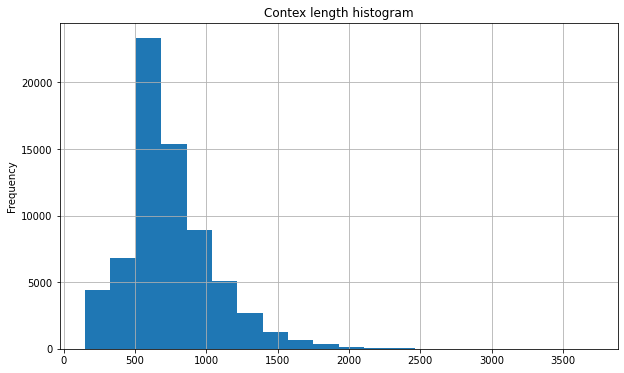

In [15]:
figsize = (10,6)
train_dataframe['context'].apply(len).plot.hist(title="Contex length histogram", bins=20, figsize=figsize, grid=True)

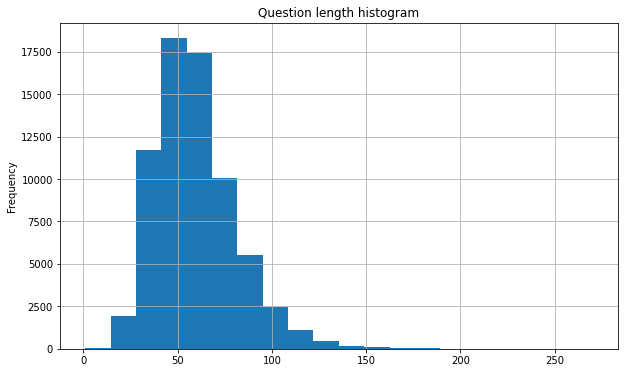

In [16]:
train_dataframe['question'].apply(len).plot.hist(title="Question length histogram", bins=20, figsize=figsize, grid=True)

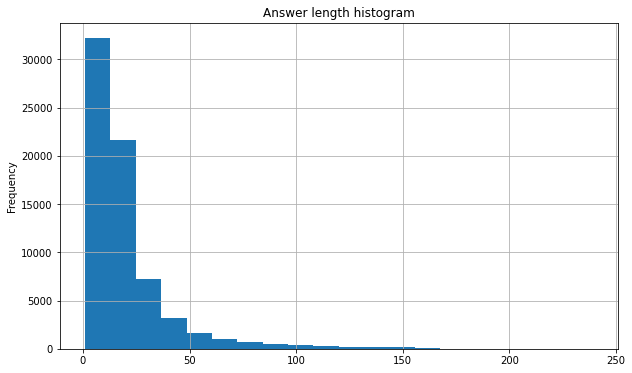

In [17]:
train_dataframe['answers.text'].apply(len).plot.hist(title="Answer length histogram", bins=20, figsize=figsize, grid=True)

In [18]:
#@title Show Samples { run: "auto", display-mode: "form" }

sample_index =  62194#@param {type:"slider", min:0, max:62194, step:1}

def print_squad_sample(df: pd.core.frame.DataFrame, line_length: int=20, separator_length: int=120) -> None:
  sample = df.iloc[sample_index]
  title = sample.title.replace('_', ' ')
  print('TITLE: ')
  print(title)
  print('='*separator_length)
  context = sample.context.split()
  print('CONTEXT: ')
  lines = [' '.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = df[df.context.values==sample.context]
  max_len = len(max(questions.question, key=len)) + 5
  print("{: <{max_len}} {: <{max_len}}".format('QUESTION:','ANSWER:', max_len=max_len))
  for idx, row in questions.iterrows():
    question = row.question
    answer = row['answers.text']
    print("{: <{max_len}} {: <{max_len}}".format(question,answer, max_len=max_len))

print_squad_sample(train_dataframe)

TITLE: 
PlayStation 3
CONTEXT: 
The console was first officially announced at E3 2005, and was released at the end of 2006. It was the
first console to use Blu-ray Disc as its primary storage medium. The console was the first PlayStation to integrate social
gaming services, included it being the first to introduce Sony's social gaming service, PlayStation Network, and its remote connectivity with
PlayStation Portable and PlayStation Vita, being able to remote control the console from the devices. In September 2009, the Slim
model of the PlayStation 3 was released, being lighter and thinner than the original version, which notably featured a redesigned
logo and marketing design, as well as a minor start-up change in software. A Super Slim variation was then released
in late 2012, further refining and redesigning the console. As of March 2016, PlayStation 3 has sold 85 million units
worldwide. Its successor, the PlayStation 4, was released later in November 2013.
QUESTION:               

#Preprocessing the training data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [19]:
from transformers import AutoTokenizer

#model_checkpoint = "t5-small" doesn't work
model_checkpoint = "distilbert-base-uncased"
#model_checkpoint = "roberta-base"
#model_checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The following assertion ensures that our tokenizer is a fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.

In [20]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

You can directly call this tokenizer on two sentences (one for the answer, one for the context):

In [21]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 25353, 22144, 2378, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Now one specific thing for the preprocessing in question answering is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`:

In [22]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

Let's find one long example in our dataset:

In [23]:
for i, example in enumerate(train_data['train']):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = train_data['train'][i]

Without any truncation, we get the following length for the input IDs:

In [24]:
len(tokenizer(example["question"], example["context"])["input_ids"])

396

Now, if we just truncate, we will lose information (and possibly the answer to our question):

In [25]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

Note that we never want to truncate the question, only the context, else the `only_second` truncation picked. Now, our tokenizer can automatically return us a list of features capped by a certain maximum length, with the overlap we talked above, we just have to tell it with `return_overflowing_tokens=True` and by passing the `stride`:

In [26]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

Now we don't have one list of `input_ids`, but several:

In [27]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 157]

And if we decode them, we can see the overlap:

In [28]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] how many wins does the notre dame men's basketball team have? [SEP] the men's basketball team has over 1, 600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 ncaa tournaments. former player austin carr holds the record for most points scored in a single game of the tournament with 61. although the team has never won the ncaa tournament, they were named by the helms athletic foundation as national champions twice. the team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending ucla's record 88 - game winning streak in 1974. the team has beaten an additional eight number - one teams, and those nine wins rank second, to ucla's 10, all - time in wins against the top team. the team plays in newly renovated purcell pavilion ( within the edmund p. joyce center ), which reopened for the beginning of the 2009 – 2010 season. the team is coached by mike brey, who, as of the 2014 – 15 season, his fifteenth at notr

Now this will give us some work to properly treat the answers: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an offset_mapping:

In [29]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 13), (14, 18), (19, 22), (23, 28), (29, 33), (34, 37), (37, 38), (38, 39), (40, 50), (51, 55), (56, 60), (60, 61), (0, 0), (0, 3), (4, 7), (7, 8), (8, 9), (10, 20), (21, 25), (26, 29), (30, 34), (35, 36), (36, 37), (37, 40), (41, 45), (45, 46), (47, 50), (51, 53), (54, 58), (59, 61), (62, 69), (70, 73), (74, 78), (79, 86), (87, 91), (92, 96), (96, 97), (98, 101), (102, 106), (107, 115), (116, 118), (119, 121), (122, 126), (127, 138), (138, 139), (140, 146), (147, 153), (154, 160), (161, 165), (166, 171), (172, 175), (176, 182), (183, 186), (187, 191), (192, 198), (199, 205), (206, 208), (209, 210), (211, 217), (218, 222), (223, 225), (226, 229), (230, 240), (241, 245), (246, 248), (248, 249), (250, 258), (259, 262), (263, 267), (268, 271), (272, 277), (278, 281), (282, 285), (286, 290), (291, 301), (301, 302), (303, 307), (308, 312), (313, 318), (319, 321), (322, 325), (326, 330), (330, 331), (332, 340), (341, 351), (352, 354), (355, 363), (364, 373), (374,

This gives, for each index of our input IDS, the corresponding start and end character in the original text that gave our token. The very first token ([CLS]) has (0, 0) because it doesn't correspond to any part of the question/answer, then the second token is the same as the characters 0 to 3 of the question:

In [30]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

how How


So we can use this mapping to find the position of the start and end tokens of our answer in a given feature. We just have to distinguish which parts of the offsets correspond to the question and which part correspond to the context, this is where the `sequence_ids` method of our `tokenized_example` can be useful:

In [31]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

It returns `None` for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature):

In [32]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

23 26


And we can double check that it is indeed the theoretical answer:

In [33]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

over 1, 600
over 1,600


For this notebook to work with any kind of models, we need to account for the special case where the model expects padding on the left (in which case we switch the order of the question and the context):

In [34]:
pad_on_right = tokenizer.padding_side == "right"

Now let's put everything together in one function we will apply to our training set.

In [35]:
def prepare_train_features(examples: collections.OrderedDict or dict) -> transformers.tokenization_utils_base.BatchEncoding:
    """Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
        in one example possible giving several features when a context is long, each of those features having a
        context that overlaps a bit the context of the previous feature.

      Args:
        examples: Squad samples
    """
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # CLS index
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        # Start/end character index of the answer in the text.
        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        # Start token index of the current span in the text.
        token_start_index = 0
        while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
            token_start_index += 1

        # End token index of the current span in the text.
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
            token_end_index -= 1

        # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
            # Note: we could go after the last offset if the answer is the last word (edge case).
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            tokenized_examples["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [36]:
features = prepare_train_features(train_data['train'][:5])

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the map method of our dataset object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training, validation and testing data will be preprocessed in one single command. Since our preprocessing changes the number of samples, we need to remove the old columns when applying it.

In [37]:
train_tokenized_datasets = train_data.map(prepare_train_features, batched=True, remove_columns=train_data['train'].column_names)

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to map to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

# Fine-tuning the model

Now that our data is ready for training, we can download the pretrained model and fine-tune it. Since our task is question answering, we use our modified version of the `DistilBertForQuestionAnswering` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us.

In [38]:
# DistilBert

import math

from transformers.modeling_outputs import QuestionAnsweringModelOutput
from transformers import DistilBertPreTrainedModel
from transformers import DistilBertModel

from torch import nn
from torch.nn import CrossEntropyLoss


def gelu(x):
    """
    Original Implementation of the GELU activation function in Google BERT repo when initially created. For
    information: OpenAI GPT's GELU is slightly different (and gives slightly different results): 0.5 * x * (1 +
    torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3)))) This is now written in C in
    torch.nn.functional Also see the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def gelu_new(x):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))


class DistilBertForQuestionAnswering(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.distilbert = DistilBertModel(config)

        self.qa_outputs_0 = nn.Linear(config.dim, 512)
        self.qa_outputs_1 = nn.Linear(512, 32)
        self.qa_outputs = nn.Linear(32, config.num_labels)
        
        assert config.num_labels == 2
        self.dropout = nn.Dropout(config.qa_dropout)

        self.LayerNorm = nn.LayerNorm(normalized_shape = [384,2])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        start_positions=None,
        end_positions=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        start_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the start of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        end_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the end of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict


        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

 
        hidden_states = distilbert_output[0]  # (bs, max_query_len, dim)
        hidden_states = self.dropout(hidden_states)  # (bs, max_query_len, dim)

        logits = gelu_new(self.qa_outputs_0(hidden_states))  # (bs, max_query_len, 2)
        logits = gelu_new(self.qa_outputs_1(logits))
        #logits = self.LayerNorm_0(logits)
      
        logits = self.qa_outputs(logits)
        logits = self.LayerNorm(logits)
       
        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)  # (bs, max_query_len)
        end_logits = end_logits.squeeze(-1)  # (bs, max_query_len)


        total_loss = None
        if start_positions is not None and end_positions is not None:

            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = nn.CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

        if not return_dict:
          output = (start_logits, end_logits) + distilbert_output[1:]
          return ((total_loss,) + output) if total_loss is not None else output
 
        return QuestionAnsweringModelOutput(
            loss=total_loss,
            start_logits=start_logits,
            end_logits=end_logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions
        )

In [39]:
from transformers import TrainingArguments, Trainer

model = DistilBertForQuestionAnswering.from_pretrained(model_checkpoint)

# Tell pytorch to run this model on the GPU.
if torch.cuda.is_available():
  model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs_0.weight', 'qa_outputs_0.bias', 'qa_outputs_1.weight', 'qa_outp

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, We've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [40]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The {} model has {:} different named parameters.\n'.format(model_checkpoint,len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layers ====\n')

for p in params[-10:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The distilbert-base-uncased model has 108 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (30522, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm

## Train

To instantiate a `Trainer`, we will need to define three more things. The most important is the `TrainingArguments`, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [41]:
batch_size = 32
args = TrainingArguments(
    output_dir='./results',
    save_total_limit=5,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    label_names=["start_positions", "end_positions"]
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay.

Then we will need a data collator that will batch our processed examples together, here the default one will work:

In [42]:
from transformers import default_data_collator

data_collator = default_data_collator

Then we just need to pass all of this along with our datasets to the `Trainer`

## Evaluation
Evaluating our model will require a bit more work, as we will need to map the predictions of our model back to parts of the context. The model itself predicts logits for the start and end position of our answers. The output of the model is a dict-like object that contains the loss (since we provided labels), the start and end logits.

We have one logit for each feature and each token. The most obvious thing to predict an answer for each feature is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

However, picking the second best answer is not as easy as picking the best one: is it the second best index in the start logits with the best index in the end logits? Or the best index in the start logits with the second best index in the end logits? And if that second best answer is not possible either, it gets even trickier for the third best answer.

To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call `n_best_size`. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one.

We also eliminate very long answers from our considerations (with an hyper-parameter we can tune).

Since one example can give several features, we will need to gather together all the answers in all the features generated by a given example, then pick the best one. We need to build a map from example index to its corresponding features indices.


 All combined together, this gives us this `post-processing` function:

In [43]:
import collections
from tqdm import tqdm, tqdm_notebook


def postprocess_qa_predictions(examples: datasets.arrow_dataset.Dataset,
                               features: datasets.arrow_dataset.Dataset,
                               raw_predictions: tuple,
                               n_best_size: int = 20,
                               max_answer_length: int = 50) -> collections.OrderedDict:
    """Function used to select the best answer from the raw predictions

      Args:
        examples: Squad samples
        features: Squad features
        raw_predictions: model predictions
    """
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer
        predictions[example["id"]] = best_answer["text"]

    return predictions

The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:

- the ID of the example that generated the feature (since each example can generate several features, as seen before);
- the offset mapping that will give us a map from token indices to character positions in the context.

That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`:

In [44]:
def prepare_validation_features(examples: collections.OrderedDict or dict) -> transformers.tokenization_utils_base.BatchEncoding:
    """To check a given span is inside the context (and not the question) and to get back the text inside.
        To do this, we need to add two things to our validation features:
        - the ID of the example that generated the feature (since each example can generate several features, as seen before);
        - the offset mapping that will give us a map from token indices to character positions in the context.
        That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`

      Args:
        examples: Squad samples
    """
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples["offset_mapping"]

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
      # CLS index
      input_ids = tokenized_examples["input_ids"][i]
      cls_index = input_ids.index(tokenizer.cls_token_id)

      # Grab the sequence corresponding to that example (to know what is the context and what is the question).
      sequence_ids = tokenized_examples.sequence_ids(i)

      # One example can give several spans, this is the index of the example containing this span of text.
      sample_index = sample_mapping[i]
      answers = examples["answers"][sample_index]

      # Start/end character index of the answer in the text.
      start_char = answers["answer_start"][0]
      end_char = start_char + len(answers["text"][0])

      # Start token index of the current span in the text.
      token_start_index = 0
      while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
          token_start_index += 1

      # End token index of the current span in the text.
      token_end_index = len(input_ids) - 1
      while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
          token_end_index -= 1

      # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
      if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
          tokenized_examples["start_positions"].append(cls_index)
          tokenized_examples["end_positions"].append(cls_index)
      else:
          # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
          # Note: we could go after the last offset if the answer is the last word (edge case).
          while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
              token_start_index += 1
          tokenized_examples["start_positions"].append(token_start_index - 1)
          while offsets[token_end_index][1] >= end_char:
              token_end_index -= 1
          tokenized_examples["end_positions"].append(token_end_index + 1)

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [45]:
validation_features = val_data['train'].map(prepare_validation_features, batched=True, remove_columns=val_data['train'].column_names)

Then we can load the metric from the datasets library, and define a function to compute it during training.

In [46]:
metric = datasets.load_metric("squad")

In [47]:
def compute_metrics(pred: transformers.trainer_utils.EvalPrediction) -> dict:
    # The Trainer hides the columns that are not used by the model (here example_id and offset_mapping which we will need for our post-processing), so we set them back
    validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

    # To get the final predictions we can apply our post-processing function to our raw predictions
    final_predictions = postprocess_qa_predictions(val_data['train'], validation_features, pred.predictions)
 
    # We just need to format predictions and labels a bit as metric expects a list of dictionaries and not one big dictionary
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in val_data["train"]]

    # Hide again the columns that are not used by the model
    validation_features.set_format(type=validation_features.format["type"], columns=['attention_mask', 'end_positions', 'input_ids', 'start_positions'])
    metrics = metric.compute(predictions=formatted_predictions, references=references)

    return metrics

## Execute the train

In [48]:
trainer = Trainer(
    model,
    args,
    compute_metrics=compute_metrics,
    train_dataset=train_tokenized_datasets["train"],
    eval_dataset=validation_features,
    data_collator=data_collator,
    tokenizer=tokenizer
)

Now we can now finetune our model by just calling the `train` method:

In [49]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

Since this training is particularly long, let's save the model just in case we need to restart.

In [ ]:
trainer.save_model(data_path + "test-squad-trained")